# Overview

This project is an implementation of the streaming, one-pass histograms described in Ben-Haim's [Streaming Parallel Decision Trees](http://jmlr.org/papers/volume11/ben-haim10a/ben-haim10a.pdf). The histograms act as an approximation of the underlying dataset. The histogram bins do not have a preset size, so as values stream into the histogram, bins are dynamically added and merged as needed. One particularly nice feature of streaming histograms is that they can be used to approximate quantiles without sorting (or even individually storing) values. Additionally, they can be used for learning, visualization, discretization, or analysis. The histograms may be built independently and merged, making them convenient for parallel and distributed algorithms.

This `Python` version of the algorithm combines ideas and code from [BigML](https://bigml.com)'s [Streaming Histograms for Clojure/Java](https://github.com/bigmlcom/histogram) and [VividCortex](https://vividcortex.com)'s [Streaming approximate histograms in Go](https://github.com/VividCortex/gohistogram).

# Installation

`streamhist` has not yet been uploaded to [PyPi](https://pypi.python.org/pypi), as we are currently at the 'pre-release' stage. Having said that you should be able to install it via `pip` directly from the GitHub repository with:

```bash
pip install git+git://github.com/carsonfarmer/streamhist.git
```

You can also install `streamhist` by cloning the [GitHub repository](https://github.com/carsonfarmer/streamhist) and using the setup script:

```bash
git clone https://github.com/carsonfarmer/streamhist.git
cd streamhist
python setup.py install
```

# Testing

`streamhist` comes with a relatively comprehensive range of tests, including unit tests and regression tests. To run the tests, you can use `pytest`, which can be installed via `pip` using the `recommended.txt` file (note, this will also install `numpy`, `matplotlib`, and `IPython` which are used for tests and examples):

```bash
pip install -r recommended.txt
pytest streamhist
```

# Features

In the following examples we use `numpy` to generate data and `matplotlib` for plotting.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")  # Makes for nicer looking plots

try:
    from functools import reduce
except ImportError:
    pass

from streamhist import StreamHist

## Basics

The simplest way to use a `StreamHist` is to initialize one and then `update` it with data points. In this first example, we create a sequence of 200k samples from a normal distribution (mean=0; variance=1) and add them to the histogram:

In [2]:
normal_data = np.random.normal(0.0, 1.0, 200000)
h1 = StreamHist(maxbins=32)  # Create histogram with 32 bins
h1.update(normal_data)       # Add points all at once

You can use the `sum` method to find the approximate number of points less than a given threshold:

In [3]:
h1.sum(0.0)

100083.47447715153

The `density` method gives us an estimate of the point density at the given location:

In [4]:
h1.density(0.0)

80110.665112511764

The `count`, `mean`, `median`, `min`, `max`, and `var` methods return useful summary statistics for the underlying dataset (some methods return approximate results). There is also a `describe` method that produces multiple summary statistics:

In [5]:
h1.describe()

{'25%': -0.70144662062746543,
 '50%': -0.0010543765097598481,
 '75%': 0.6842056241993717,
 'count': 200000,
 'max': 4.4482526912064921,
 'mean': 0.00088520840106445678,
 'min': -4.4169415722166905,
 'var': 0.99109191080479508}

Arbritrary quantiles/percentiles can be found using `quantile`:

In [6]:
h1.quantiles(0.5, 0.95, 0.99)  # Supports multiple quantile inputs

[-0.0010543765097598481, 1.6547838836416333, 2.3297886138335397]

## Sums and densities

We can plot the sums and density estimates as functions. First we compute the data bounds and then we create 100 linearly spaced numbers whithin those bounds for plotting:

In [7]:
l, u = h1.bounds()
x = np.linspace(l, u, 100)

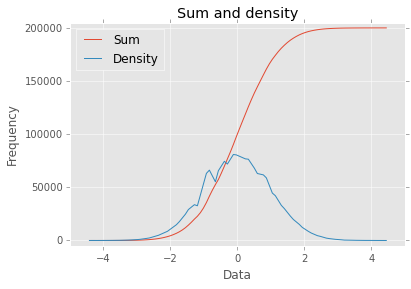

In [8]:
plt.figure()
y1 = [h1.sum(z) for z in x]
y2 = [h1.density(z) for z in x]
plt.plot(x, y1, label="Sum")
plt.plot(x, y2, label="Density")
plt.title("Sum and density")
plt.ylabel("Frequency")
plt.xlabel("Data")
plt.legend(loc="best")
plt.ylim(-5000, 205000)
plt.show()

If we normalized the values (dividing by 200K), these lines approximate the [cumulative distribution function](http://en.wikipedia.org/wiki/Cumulative_distribution_function) (CDF) and the [probability density function](http://en.wikipedia.org/wiki/Probability_density_function)  (PDF) for the normal distribution. Alternatively, we can compute the CDF and PDF directly:

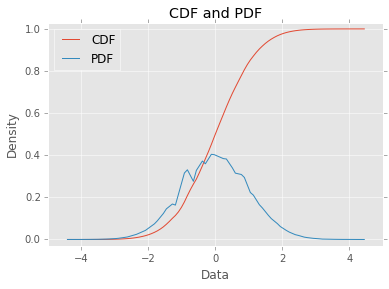

In [9]:
plt.figure()
y1 = [h1.cdf(z) for z in x]
y2 = [h1.pdf(z) for z in x]
plt.plot(x, y1, label="CDF")
plt.plot(x, y2, label="PDF")
plt.title("CDF and PDF")
plt.ylabel("Density")
plt.xlabel("Data")
plt.legend(loc="best")
plt.ylim(-0.03, 1.03)
plt.show()

## Bin counts

The histogram approximates distributions using a constant number of bins. This bin limit can be specified as parameter when creating a `StreamHist` object (`maxbins` defaults to 64). A bin contains a `count` of the points within the bin along with the `mean` for the values in the bin. The edges of the bin aren't explicitly captured. Instead the histogram assumes that points of a bin are distributed with half the points less than the bin mean and half greater. This explains the fractional sum in the following example.

In [10]:
h2 = StreamHist(maxbins=3).update([1, 2, 3])
list(h2.bins)

[{'count': 1, 'mean': 1}, {'count': 1, 'mean': 2}, {'count': 1, 'mean': 3}]

In [11]:
h2.sum(2.)

1.0

As mentioned earlier, the bin limit constrains the number of unique bins a histogram can use to capture a distribution. The histogram above was created with a limit of just three bins. When we add a fourth unique value it will create a fourth bin and then merge the nearest two.

In [12]:
h2.update(0.5)
list(h2.bins)

[{'count': 2, 'mean': 0.75}, {'count': 1, 'mean': 2}, {'count': 1, 'mean': 3}]

A larger bin limit means a higher quality picture of the distribution, but it also means a larger memory footprint. In the following example, we create two new histograms based on a sequence of 300K samples from a mixture of four Gaussian distributions (means=0, 1, 2, 3; variance=0.2):

In [13]:
mixed_normal_data = np.concatenate((
    np.random.normal(0.0, 0.2, 160000),
    np.random.normal(1.0, 0.2, 80000),
    np.random.normal(2.0, 0.2, 40000),
    np.random.normal(3.0, 0.2, 20000)
    ))
np.random.shuffle(mixed_normal_data)

In [14]:
h3 = StreamHist(maxbins=8).update(mixed_normal_data)
h4 = StreamHist(maxbins=64).update(mixed_normal_data)

In the plot below, the red line represents the PDF for the histogram with 8 bins and the blue line represents the PDF for the histogram with 64 bins.

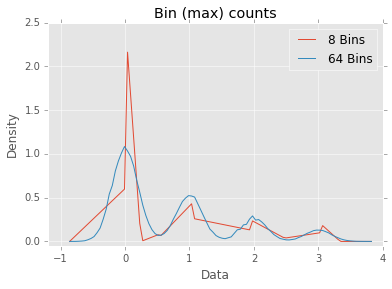

In [15]:
l, u = h4.bounds()
x = np.linspace(l, u, 100)

plt.figure()
y1 = [h3.pdf(z) for z in x]
y2 = [h4.pdf(z) for z in x]
plt.plot(x, y1, label="8 Bins")
plt.plot(x, y2, label="64 Bins")
plt.legend(loc="best")
plt.title("Bin (max) counts")
plt.ylabel("Density")
plt.xlabel("Data")
plt.xlim(-1.2, 4)
plt.ylim(-0.05, None)
plt.show()

## Bin weighting

Another option when creating a histogram is to use *gap weighting*. When `weighted` is `True`, the histogram is encouraged to spend more of its bins capturing the densest areas of the distribution. For the normal distribution that means better resolution near the mean and less resolution near the tails. The chart below shows a histogram with gap weighting in red and without gap weighting in blue. Near the center of the distribution, red uses more bins and better captures the Gaussian distribution's true curve.

In [16]:
h5 = StreamHist(maxbins=8, weighted=True).update(normal_data)
h6 = StreamHist(maxbins=8, weighted=False).update(normal_data)

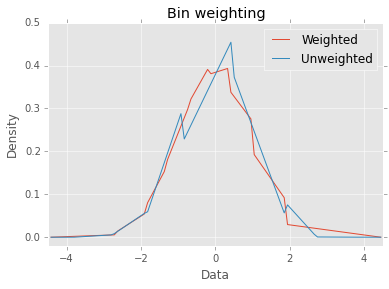

In [17]:
l, u = h5.bounds()
x = np.linspace(l, u, 100)

plt.figure()
y1 = [h5.pdf(z) for z in x]
y2 = [h6.pdf(z) for z in x]
plt.plot(x, y1, label="Weighted")
plt.plot(x, y2, label="Unweighted")
plt.legend(loc="best")
plt.title("Bin weighting")
plt.ylabel("Density")
plt.xlabel("Data")
plt.xlim(-4.5, 4.5)
plt.ylim(-0.02, None)
plt.show()

## Merging

A strength of the streaming histograms is their ability to merge with one another. Histograms can be built on separate data streams (and/or nodes, processes, clusters, etc) and then combined to give a better overall picture.

In this example, we first create 300 samples from the mixed Gaussian data, and then stream each sample through its own `StreamHist` instance (for a total of 300 unique `StreamHist` objects). We then merge the 300 noisy histograms to form a single merged histogram:

In [18]:
# Create 300 samples from the mixed Gaussian data
samples = np.split(mixed_normal_data, 300)

# Create 300 histograms from the noisy samples
# This might take a few seconds...
hists = [StreamHist().update(s) for s in samples]

# Merge the 300 histograms
h7 = sum(hists)  # How cool is that!

In the following plot, the red line shows the density distribution from the merged histogram, and the blue line shows one of (the last one in the list) the original histograms:

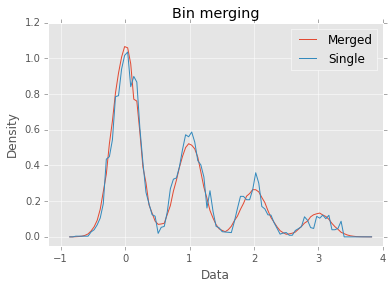

In [20]:
min, max = h7.bounds()
x = np.linspace(min, max, 100)

plt.figure()
y1 = [h7.pdf(z) for z in x]
y2 = [hists[-1].pdf(z) for z in x]
plt.plot(x, y1, label="Merged")
plt.plot(x, y2, label="Single")
plt.legend(loc="best")
plt.title("Bin merging")
plt.ylabel("Density")
plt.xlabel("Data")
plt.xlim(-1.2, 4)
plt.ylim(-0.05, None)
plt.show()

## Missing Values

Information about missing values is captured whenever the input value is `None`. The `missing_count` property retrieves the number of instances with a missing input. For a basic histogram, this count is likely sufficient. It is provided in the case that this type of information is relevant for more complex summaries.

In [21]:
h8 = StreamHist().update([None, 7, None])
h8.missing_count

2

## Performance-related concerns

### Freezing a `StreamHist`

While the ability to adapt to non-stationary data streams is a strength of the histograms, it is also computationally expensive. If your data stream is stationary, you can increase the histogram's performance by setting the `freeze` threshold parameter. After the number of inserts into the histogram have exceeded the `freeze` parameter, the histogram bins are 'locked' into place. As the bin means no longer shift, inserts become computationally cheap. However the quality of the histogram can suffer if the `freeze` parameter is too small.

In [22]:
# This takes quite a while (~2.7s each run for the 'frozen' histogram)...
%timeit StreamHist().update(normal_data)
%timeit StreamHist(freeze=1024).update(normal_data)

1 loops, best of 3: 11.2 s per loop
1 loops, best of 3: 2.65 s per loop


### Sorted list

The bin reservoir used to store the `StreamHist` bins is a sorted list as implemented in the [`SortedContainers`](https://github.com/grantjenks/sorted_containers) library. There are many performance-related reasons for using this library, and [implementation details](http://www.grantjenks.com/docs/sortedcontainers/implementation.html) and [performance comparisons](http://www.grantjenks.com/docs/sortedcontainers/performance.html) are available for those who are interested.

### Update speeds

Currently, `StreamHist` has minimal dependencies. The only non-standard library dependency is [`SortedContainers`](https://github.com/grantjenks/sorted_containers). This has been a concious design choice. However, in order to improve update speeds (and other bottlenecks), we are exploring other options, including the use of [`NumPy`](http://www.numpy.org), which provides fast, powerful array-like objects, useful linear algebra, and other features which may improve scalability and efficiency.

## Rendering/plotting

There are multiple ways to visualize a `StreamHist` histogram. Several of the examples here provide ways of plotting the outputs via `matplotlib`. In addition, there are two methods which provide quick access to histogram plotting functionality: `compute_breaks` which provides histogram breaks similarly to `numpy.histogram` and `print_breaks`, which 'prints' the histogram breaks to the console for quick visualization.

In [23]:
from numpy import histogram, allclose
length = normal_data.shape[0]
bins = 25
h9 = StreamHist().update(normal_data)
hist1, bins1 = h9.compute_breaks(bins)
hist2, bins2 = histogram(normal_data, bins=bins)

if allclose(bins1, bins2):
    print("The bin breaks are all close")
if allclose(hist1, hist2, rtol=1, atol=length/(bins**2)):
    print("The bin counts are all close")

The bin breaks are all close
The bin counts are all close


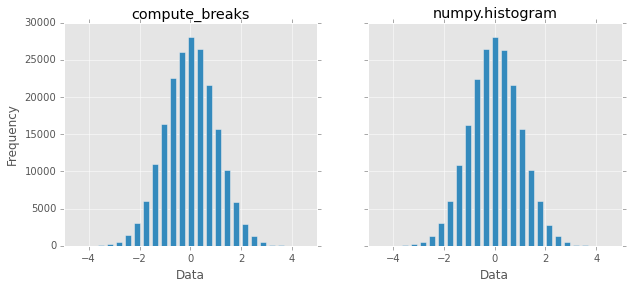

In [24]:
width = 0.7 * (bins2[1] - bins2[0])
c1 = [(a + b)/2. for a, b in zip(bins1[:-1], bins1[1:])]
c2 = [(a + b)/2. for a, b in zip(bins2[:-1], bins2[1:])]

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 4))
ax1.bar(c1, hist1, align='center', width=width)
ax2.bar(c2, hist2, align='center', width=width)
ax1.set_title("compute_breaks")
ax2.set_title("numpy.histogram")
ax1.set_ylabel("Frequency")
ax1.set_xlabel("Data")
ax2.set_xlabel("Data")
plt.show()

In [25]:
h9.print_breaks(bins)

-4.41694157222	
-4.06233380168	
-3.70772603114	
-3.35311826061	
-2.99851049007	
-2.64390271953	.
-2.289294949	...
-1.93468717846	.....
-1.58007940792	..........
-1.22547163738	................
-0.870863866847	......................
-0.51625609631	..........................
-0.161648325774	............................
0.192959444763	..........................
0.5475672153	.....................
0.902174985837	...............
1.25678275637	..........
1.61139052691	.....
1.96599829745	..
2.32060606798	.
2.67521383852	
3.02982160906	
3.3844293796	
3.73903715013	
4.09364492067	



# License

Copyright © 2015 Carson Farmer [carsonfarmer@gmail.com](mailto:carsonfarmer@gmail.com)  
Copyright © 2013 VividCortex  
All rights reserved. MIT Licensed.  
Copyright © 2013 BigML  
Licensed under the Apache License, Version 2.0  